# Import Libraries

In [2]:
# optional
!rm -rf /tmp/satelite

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pathlib
import os
import zipfile
import shutil

# Datasets

https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/download?datasetVersionNumber=1

# Unzip dataset.zip

In [4]:
local_zip = '/content/drive/MyDrive/kaggle/satelite.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/satelite')
zip_ref.close()

In [5]:
base_dir = '/tmp/satelite/'
image_dir = os.path.join(base_dir, 'data')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

list = [train_dir, validation_dir]
for dir in list:
    os.mkdir(dir)

In [6]:
desert_dir = os.path.join(image_dir, 'desert')
cloudy_dir = os.path.join(image_dir, 'cloudy')
water_dir = os.path.join(image_dir, 'water')
green_area_dir = os.path.join(image_dir, 'green_area')

train_desert_dir = os.path.join(train_dir, 'desert')
train_cloudy_dir = os.path.join(train_dir, 'cloudy')
train_water_dir = os.path.join(train_dir, 'water')
train_green_area_dir = os.path.join(train_dir, 'green_area')

val_desert_dir = os.path.join(validation_dir, 'desert')
val_cloudy_dir = os.path.join(validation_dir, 'cloudy')
val_water_dir = os.path.join(validation_dir, 'water')
val_green_area_dir = os.path.join(validation_dir, 'green_area')

In [7]:
list1 = [train_desert_dir, train_cloudy_dir, train_water_dir, train_green_area_dir,
         val_desert_dir, val_cloudy_dir, val_water_dir, val_green_area_dir]
for folder in list1:
    os.mkdir(folder)

# Preprocessing Data

In [8]:
from sklearn.model_selection import train_test_split

train_desert, val_desert = train_test_split(os.listdir(desert_dir), test_size=0.2, random_state=42)
train_cloudy, val_cloudy = train_test_split(os.listdir(cloudy_dir), test_size=0.2, random_state=42)
train_water, val_water = train_test_split(os.listdir(water_dir), test_size=0.2, random_state=42)
train_green_area, val_green_area = train_test_split(os.listdir(green_area_dir), test_size=0.2, random_state=42)

for file in train_desert:
    shutil.copy(os.path.join(desert_dir, file), os.path.join(train_desert_dir, file))
for file in val_desert:
    shutil.copy(os.path.join(desert_dir, file), os.path.join(val_desert_dir, file))

for file in train_cloudy:
    shutil.copy(os.path.join(cloudy_dir, file), os.path.join(train_cloudy_dir, file))
for file in val_cloudy:
    shutil.copy(os.path.join(cloudy_dir, file), os.path.join(val_cloudy_dir, file))

for file in train_water:
    shutil.copy(os.path.join(water_dir, file), os.path.join(train_water_dir, file))
for file in val_water:
    shutil.copy(os.path.join(water_dir, file), os.path.join(val_water_dir, file))

for file in train_green_area:
    shutil.copy(os.path.join(green_area_dir, file), os.path.join(train_green_area_dir, file))
for file in val_green_area:
    shutil.copy(os.path.join(green_area_dir, file), os.path.join(val_green_area_dir, file))

# Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(224, 224)
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator  = validation_datagen.flow_from_directory(
    validation_dir,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.


# Modelling

In [10]:
ACCURACY_THRESHOLD = 0.92

class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get('accuracy') > ACCURACY_THRESHOLD) and logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n Akurasi lebih dari 92%")
            self.model.stop_training = True

callbacks = myCallbacks()


In [11]:
pre_trained_model = MobileNetV2()

14536120/14536120 [==============================] - 0s 0us/step


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 373248)            0         
                                                                 
 dense (Dense)               (None, 256)               9

In [15]:
hist = model.fit(train_generator,
                 epochs=40,
                 batch_size=128,
                 validation_data=validation_generator,
                 callbacks=[callbacks])

Epoch 1/40
141/141 [==============================] - 89s 512ms/step - loss: 0.6544 - accuracy: 0.6980 - val_loss: 0.3961 - val_accuracy: 0.8137
Epoch 2/40
141/141 [==============================] - 71s 499ms/step - loss: 0.4267 - accuracy: 0.8284 - val_loss: 0.3779 - val_accuracy: 0.8456
Epoch 3/40
141/141 [==============================] - 69s 491ms/step - loss: 0.4085 - accuracy: 0.8408 - val_loss: 0.3191 - val_accuracy: 0.8758
Epoch 4/40
141/141 [==============================] - 71s 500ms/step - loss: 0.3917 - accuracy: 0.8441 - val_loss: 0.3176 - val_accuracy: 0.8696
Epoch 5/40
141/141 [==============================] - 71s 503ms/step - loss: 0.3218 - accuracy: 0.8777 - val_loss: 0.2599 - val_accuracy: 0.8935
Epoch 6/40
141/141 [==============================] - 70s 499ms/step - loss: 0.3131 - accuracy: 0.8748 - val_loss: 0.2661 - val_accuracy: 0.8793
Epoch 7/40
141/141 [==============================] - 70s 494ms/step - loss: 0.2922 - accuracy: 0.8810 - val_loss: 0.2345 - val_ac

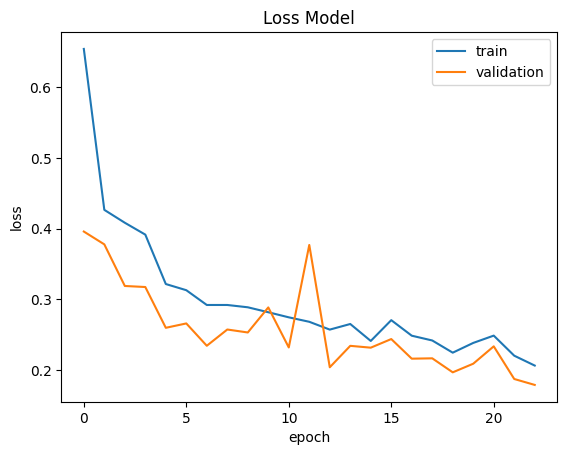

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

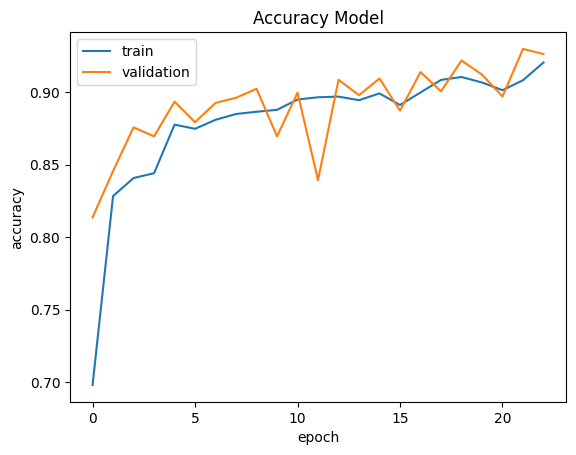

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

labels = ['cloudy', 'desert', 'green_area', 'water']

def test():
    uploaded = files.upload()
    for filename in uploaded.keys():
        path = filename
        img = image.load_img(path, target_size=(224,224))

        imgplot = plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = model.predict(images, batch_size=32)
        print(labels[np.argmax(classes)])

In [ ]:
test()